In [1]:
import numpy as np
import networkx as nx
from matplotlib import pyplot as plt
import networkxAO as nao

## Drawing self-edges

NetworkX's draw functions ignore self-edges. I doubt that there is going to be an official fix for this in versions to come because it would require that networkX layouts are not just a dictionary of node positions but also include info about the orientation of self-edges. It also seems rather hard to get, for example, `nx.layout.spring_layout()` or `nx.layout.spectral_layout()` to return layouts that ensure that self-edges do not overlap with non-self-edges. The function `nao.draw_networkx_selfedges()` draws self-edges for a networkx graph, but it does not guarantee that the self-edges do not overlap with other edges. You can fix that manually by using a shell layout and setting `orientation='radial'`. Alternatively, you can set the orientation of each self-edge manually.

In [2]:
# Let's take a Watts Strogatz network
g = nx.watts_strogatz_graph(10, 4, 0.2)
# Add some self-edges
g.add_edges_from([[i,i] for i in [1,2,4,5,6,8]])
# We choose a shell layout but others are fine too
pos = nx.layout.shell_layout(g)

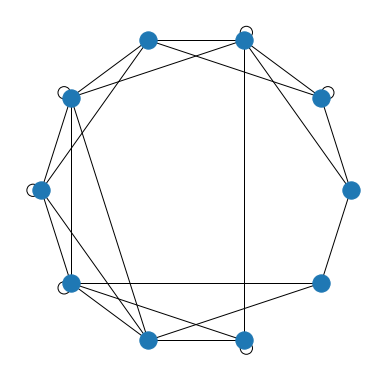

In [3]:
# Let's draw a graph with self-edges using small black arcs that "point" away from the graph's center
plt.figure(figsize=(5,5))
# First, we draw everything but the self-edges
nx.draw(g,pos)
# Now we draw self-edges
nao.draw_networkx_selfedges(g,pos, orientation="radial", arc_size=0.5)

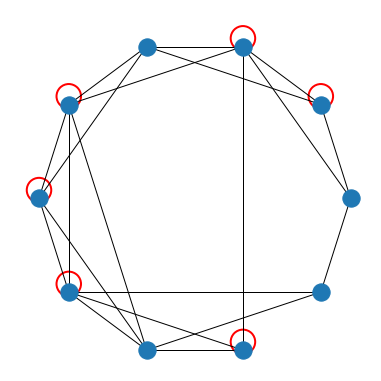

In [4]:
# Let's do this again, but with thick large red self-edge that all point upwards
plt.figure(figsize=(5,5))
nx.draw(g, pos)
nao.draw_networkx_selfedges(g,pos, orientation=90, arc_size=2, selfedge_color="red", linewidths=2)

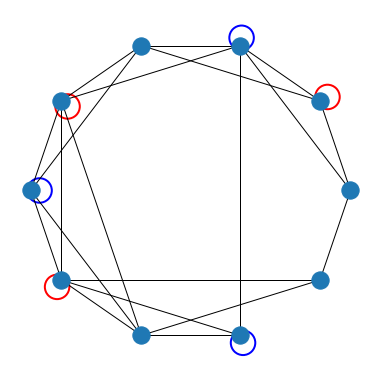

In [5]:
# Let's let all self-edges point to different directions
orientations = [0,30,80,0,-45,0,240,0,290,0]
# and color self-edges at nodes with even node labels red and self-edges at nodes with uneven node labels blue
colors = ['red','blue']*5

plt.figure(figsize=(5,5))
nx.draw(g,pos)
nao.draw_networkx_selfedges(g,pos, orientation=orientations, arc_size=2, selfedge_color=colors, linewidths=2) 

## Optimal permutation layout
For a given layout, the function `nao.optimal_permutation_layout()` finds a permutation of node positions that gives us and _optimal_ layout and returns the permuted layout. With _optimal_ I mean that the sum of edge lengths is as small as possible. You can set _optimal_ to mean something else by making changes to the helper function `nao._layout_cost()`. The function `nao.optimal_layout_permutation()` finds a global optimum by computing the layout cost (i.e., the sum of edge lengths) for every(!) permutation node positions in the layout. Looping over all permutations of nodes scales very badly. On my PC, this works fairly well for graphs up to 6 or 7 nodes. Use for larger networks at your own risk!

I wrote this function with `nx.layout.shell)layout()` in mind, but you can use it for other layouts, too. Layouts  that aim to minimize the total edge length already (e.g., `nx.layout.spring_layout()`) tend to have an optimal ordering of nodes, so running `nao.optimal_permutation_layout()` on these layouts is probably a waste of time.

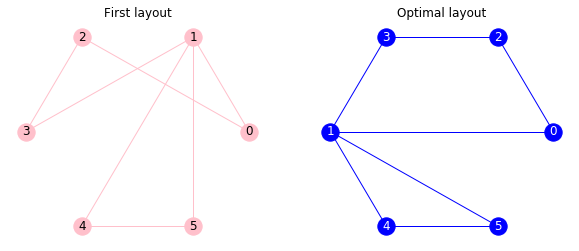

In [6]:
# Make a small graph
g = nx.Graph()
g.add_edges_from([[0,1],[0,2],[1,3],[1,4],[1,5],[2,3],[4,5]])
# Get a shell layout
pos = nx.layout.shell_layout(g)
# Let's get an optimal shell layout
pos2, layout_cost = nao.optimal_permutation_layout(g, pos)

# Draw both layouts side by side
plt.figure(figsize=(10,4))

plt.subplot(121)
plt.title('First layout')
nx.draw(g, pos, node_color='pink', edge_color='pink')
labels = nx.draw_networkx_labels(g, pos, dict(zip(range(6),range(6))))

plt.subplot(122)
plt.title('Optimal layout')
nx.draw(g, pos2, node_color='blue', edge_color='blue')
labels = nx.draw_networkx_labels(g, pos2, dict(zip(range(6),range(6))), font_color='white')

## Optimal permutation layout with constraints and the 'oriented' shell layout
The function `nao.optimal_permutation_layout_with_constraints()` does exactly the same thing as `nao.optimal_permutation_layout()`, but it allows you fix some node positions. The function `nao.oriented_shell()` uses `nao.optimal_permutation_layout_with_constraints()` to find an optimal shell layout that has a maximum-degree node or a node with a self-edge as its first node (i.e., the node with position (1,0)).

### Example for `nao.optimal_permutation_layout_with_constraints()`

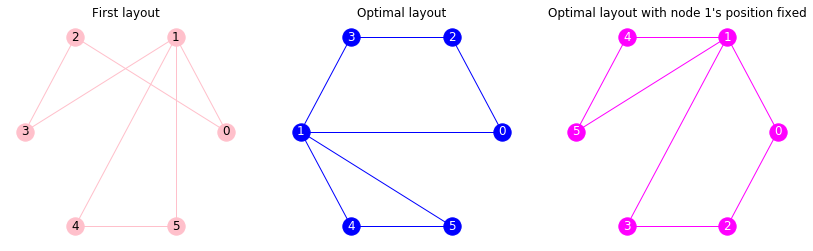

In [7]:
# Make a small graph (same as before)
g = nx.Graph()
g.add_edges_from([[0,1],[0,2],[1,3],[1,4],[1,5],[2,3],[4,5]])
# Get a shell layout
pos = nx.layout.shell_layout(g)
# Let's get an optimal shell layout
pos2, layout_cost = nao.optimal_permutation_layout(g, pos)
# Let's get an optimal shell layout when the nodes 1 and 2 are fixed to their original positions
pos3, layout_cost = nao.optimal_permutation_layout_with_constraints(g, pos, [1])

# Draw layouts side by side
plt.figure(figsize=(14,4))

plt.subplot(131)
plt.title('First layout')
nx.draw(g, pos, node_color='pink', edge_color='pink')
labels = nx.draw_networkx_labels(g, pos, dict(zip(pos2.keys(),pos2.keys())))

plt.subplot(132)
plt.title('Optimal layout')
nx.draw(g, pos2, node_color='blue', edge_color='blue')
labels = nx.draw_networkx_labels(g, pos2, dict(zip(pos2.keys(),pos2.keys())), font_color='white')

plt.subplot(133)
plt.title("Optimal layout with node 1's position fixed")
nx.draw(g, pos3, node_color='magenta', edge_color='magenta')
labels = nx.draw_networkx_labels(g, pos3, dict(zip(pos3.keys(),pos3.keys())), font_color='white')

### Example for `nao.oriented_shell()`

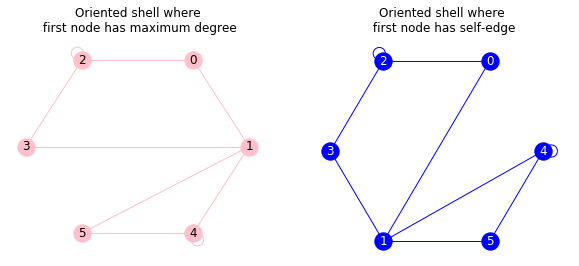

In [8]:
# Make a small graph (same as before but with a few self-edges)
g = nx.Graph()
g.add_edges_from([[0,1],[0,2],[2,2],[1,3],[1,4],[1,5],[2,3],[4,4],[4,5]])
# Let's get an oriented shell layout with first node = maximum degree node
pos2, lowest_cost = nao.oriented_shell(g, select='degree')
# Let's get an oriented shell layout with first node = self-edge node
pos3, lowest_cost = nao.oriented_shell(g, select='selfedge')

# Draw layouts side by side
plt.figure(figsize=(10,4))

plt.subplot(121)
plt.title('Oriented shell where\n first node has maximum degree')
nx.draw(g, pos2, node_color='pink', edge_color='pink')
nao.draw_networkx_selfedges(g, pos2, selfedge_color='pink')
labels = nx.draw_networkx_labels(g, pos2, dict(zip(pos2.keys(),pos2.keys())))

plt.subplot(122)
plt.title('Oriented shell where\n first node has self-edge')
nx.draw(g, pos3, node_color='blue', edge_color='blue')
nao.draw_networkx_selfedges(g, pos3, selfedge_color='blue')
labels = nx.draw_networkx_labels(g, pos3, dict(zip(pos3.keys(),pos3.keys())), font_color='white')

## Sets of nonisomorphic subgraphs
The function `nao.set_of_nonisomorphic_graphs()` returns a list of non-isomorphic graphs for a specified number of nodes and edges. It uses `nx.is_isormophic()` to determine if a pair of graphs is isomorphic. This function is a _flexible_ tool for enumerating motifs in network structure. It is probably much slower than existing routines for finding non-isomorphic subgraphs in Fortran or C. On my machine, `nao.set_of_nonisomorphic_graphs()` runs in seconds for 3 or 4 edges. It runs in less than one hour for 6. I have not run it for 7 edges.

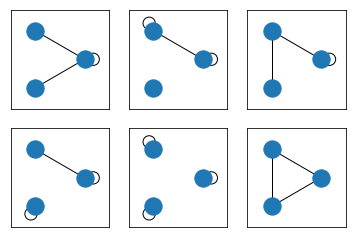

In [11]:
#Get undirected graphs with 3 nodes and 3 edges
list_of_graphs = nao.set_of_nonisomorphic_graphs(3,3, load=False, save=False, directed=False)

plt.figure(figsize=(6,4))
for i,g in enumerate(list_of_graphs):
    ax = plt.subplot(2,3,i+1)
    ax.set_xlim([-1.25,1.75])
    ax.set_ylim([-1.5,1.5])
    shell = nx.layout.shell_layout(g)
    nx.draw(g, shell)
    nao.draw_networkx_selfedges(g, shell)
    ax.axis('on')